# R(t) Estimation using a Renewal Equation model

This example shows how to estimate time-dependent trajectories of the reproduction number $R(t)$ using the Renewal Equation model.

$$I(t) \sim \text{Poisson}(R(t)\sum^{t-1}_{s=1}w(s) I(t-s))$$

where $R(t)$ is the instantaneous reproduction number at time $t$ and $w(s)$ is the value of the serial interval at time $s$.

We also consider an alternative approach which assumes a Negative Binomial distribution on the noise instead:

$$I(t) \sim \text{NegBin}(R(t)\sum^{t-1}_{s=1}w(s) I(t-s), \phi)$$

where $\phi$ represents the overdispersion parameter.

In [1]:
import pints
import pints.plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
from scipy.special import loggamma, digamma

We use SARS epidemic data in our analysis, with a customised serial interval. We read in the data and plot the incidence over 107 days.

In [2]:
# Read SARS serial interval
serial_interval = pd.read_csv('sars_serial_interval.csv')['w'].values

# Read SARS data
data = pd.read_csv('sars_incidence.csv')
cases = data['incidence'].values
times = data['day'].values

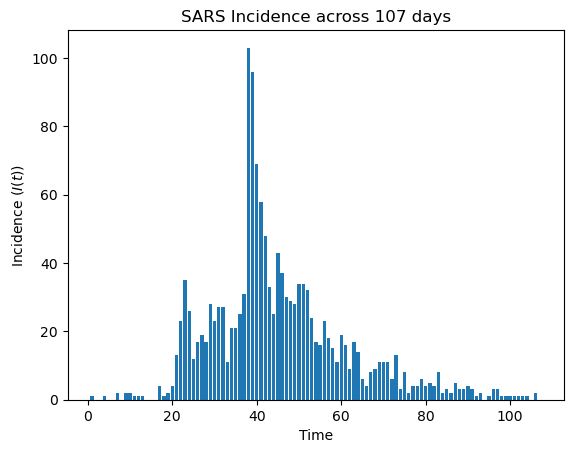

In [3]:
# Plot (bar chart cases each day)
plt.bar(times, cases)

plt.title('SARS Incidence across 107 days')
plt.xlabel('Time')
plt.ylabel(r'Incidence ($I(t)$)')
plt.show()

## Poisson Noise model

We first write class that computes the log-likelihood and its partial derivatives used for the runnning NUTS sampling method in pints. For compatibility, we set our log-likelihood object class to inherit from the <code>pints.LogLikelihood</code> class.

In [4]:
class PoissonBranchingLogLikelihood(pints.LogLikelihood):
    """
    Log-likelihood of Poisson branching process.

    Parameters
    ----------
    inc_data
        (pandas Dataframe) Dataframe of the numbers of new cases by time unit
        (usually days).
        Data stored in columns of with one for time and one for incidence
        number, respectively.
    daily_serial_interval
        (list) Unnormalised probability distribution of that the recipient
        first displays symptoms s days after the infector first displays
        symptoms.
    tau
        (numeric) size sliding time window over which the reproduction number
        is estimated.
    imported_inc_data
        (pandas Dataframe) contains numbers of imported new cases by time unit
        (usually days).
        Data stored in columns of with one for time and one for incidence
        number, respectively.
    epsilon
        (numeric) Proportionality constant of the R number for imported cases
        with respect to its analog for local ones.
    time_key
        label key given to the temporal data in the inc_data dataframe.
    inc_key
        label key given to the incidental data in the inc_data dataframe.

    """
    def __init__(self, inc_data, daily_serial_interval, tau,
                 imported_inc_data=None, epsilon=None,
                 time_key='Time', inc_key='Incidence Number'):

        # Local incidence data
        if not issubclass(type(inc_data), pd.DataFrame):
            raise TypeError('Incidence data has to be a dataframe')

        self._check_serial(daily_serial_interval)

        if time_key not in inc_data.columns:
            raise ValueError('No time column with this name in given data')

        if inc_key not in inc_data.columns:
            raise ValueError(
                'No incidence column with this name in given data')

        data_times = inc_data[time_key]

        # Pad with zeros the time points where we have no information on
        # the number of incidences
        padded_inc_data = inc_data.set_index(time_key).reindex(
            range(
                min(data_times), max(data_times)+1)
                ).fillna(0).reset_index()

        # Imported cases data
        if imported_inc_data is not None:
            if not issubclass(type(imported_inc_data), pd.DataFrame):
                raise TypeError(
                    'Imported incidence data has to be a dataframe')

            if time_key not in imported_inc_data.columns:
                raise ValueError('No time column with this name in given data')

            if inc_key not in imported_inc_data.columns:
                raise ValueError(
                    'No imported incidence column with this name in given' +
                    ' data')

            data_times = inc_data[time_key]

            # Pad with zeros the time points where we have no information on
            # the number of imported incidences
            padded_imp_inc_data = imported_inc_data.set_index(
                time_key).reindex(range(
                    min(data_times), max(data_times)+1)
                    ).fillna(0).reset_index()
        else:
            padded_imp_inc_data = pd.DataFrame(
                0, columns=padded_inc_data.columns,
                index=padded_inc_data.index)

        # Set the prerequisites for the inference wrapper
        # Model and Incidence data
        self.cases_labels = list(padded_inc_data[[time_key, inc_key]].columns)
        self.cases_data = padded_inc_data[inc_key].to_numpy()
        self.cases_times = padded_inc_data[time_key]
        self.imp_cases_labels = list(
            padded_imp_inc_data[[time_key, inc_key]].columns)
        self.imp_cases_data = padded_imp_inc_data[inc_key].to_numpy()
        self.imp_cases_times = padded_imp_inc_data[time_key]

        self._serial_interval = np.asarray(daily_serial_interval)[::-1]
        self._normalizing_const = np.sum(self._serial_interval)

        # Sliding window length
        self._tau = tau

        # Set proportionality constant
        if epsilon is not None:
            self.set_epsilon(epsilon)
        else:
            self.set_epsilon(0)

        # Precompute quantities for the log-likelihood computation and its
        # derivatives
        self._log_lik_precomp()

    def set_epsilon(self, new_epsilon):
        """
        Updates proportionality constant of the R number for imported cases
        with respect to its analog for local ones.

        Parameters
        ----------
        new_epsilon
            new value of constant of proportionality.

        """
        if not isinstance(new_epsilon, (int, float)):
            raise TypeError('Value of epsilon must be integer or float.')
        if new_epsilon < 0:
            raise ValueError('Epsilon needs to be greater or equal to 0.')

        self.epsilon = new_epsilon

        # Recompute quantities for the log-likelihood computation and its
        # derivatives
        self._log_lik_precomp()

    def n_parameters(self):
        """
        Returns number of parameters for log-likelihood object.

        Returns
        -------
        int
            Number of parameters for log-likelihood object.

        """
        return np.shape(self.cases_data)[0] - self._tau - 1

    def _check_serial(self, si):
        """
        Checks serial interval is iterable and only contains numeric values.
        """
        try:
            float(next(iter(si)))
        except (TypeError, StopIteration):
            raise TypeError(
                'Daily Serial Interval distributions must be iterable')
        except ValueError:
            raise TypeError('Daily Serial Interval distribution must contain \
                            numeric values')

    def get_serial_intervals(self):
        """
        Returns serial intervals for the model.

        Returns
        -------
        list
            Serial intervals for the model.

        """
        # Reverse inverting of order of serial intervals
        return self._serial_interval[::-1]

    def set_serial_intervals(self, serial_intervals):
        """
        Updates serial intervals for the model.

        Parameters
        ----------
        serial_intervals
            New unnormalised probability distribution of that the recipient
            first displays symptoms s days after the infector first displays
            symptoms.

        """
        if np.asarray(serial_intervals).ndim != 1:
            raise ValueError(
                'Chosen times storage format must be 1-dimensional')

        # Invert order of serial intervals for ease in _effective_no_infectives
        self._serial_interval = np.asarray(serial_intervals)[::-1]
        self._normalizing_const = np.sum(self._serial_interval)

        # Recompute quantities for the log-likelihood computation and its
        # derivatives
        self._log_lik_precomp()

    def _infectious_individuals(self, cases_data, t):
        """
        Computes expected number of new cases at time t, using previous
        incidences and serial intervals.

        Parameters
        ----------
        cases_data
            (1D numpy array) contains numbers of cases occuring in each time
            unit (usually days) including zeros.
        t
            evaluation time
        """
        if t > len(self._serial_interval):
            start_date = t - len(self._serial_interval) - 1
            eff_num = (
                (cases_data[start_date:(t-1)] * self._serial_interval).sum() /
                self._normalizing_const)
            return eff_num

        eff_num = (
            (cases_data[:(t-1)] * self._serial_interval[-(t-1):]).sum() /
            self._normalizing_const)

        return eff_num

    def _infectives_in_tau(self, cases_data, start, end):
        """
        Get number of infectives in tau window.

        Parameters
        ----------
        cases_data
            (1D numpy array) contains numbers of cases occuring in each time
            unit (usually days) including zeros.
        start
            start time of the time window in which to calculate effective
            number of infectives.
        end
            end time of the time window in which to calculate effective number
            of infectives.
        """
        num = []
        for time in range(start, end):
            num += [self._infectious_individuals(cases_data, time)]
        return num

    def _compute_log_likelihood(self, r_profile):
        """
        Computes the log-likelihood evaluated a given choice of
        R numbers timeline for the branching process model.

        Parameters
        ----------
        r_profile : list
            Time-dependent R numbers trajectory for which
            the log-likelihood is computed for.

        Returns
        -------
        float
            Value of the log-likelihood evaluated at the given choice of
            R numbers timeline.
        """
        total_time = self.cases_times.max() - self.cases_times.min() + 1
        time_init_inf_r = self._tau + 1

        Ll = 0

        for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
            Ll += np.log(r_profile[_]) * np.sum(self.slice_cases[_])
            Ll += np.sum(
                np.multiply(self.slice_cases[_], self.log_tau_window[_]))
            Ll += - r_profile[_] * self.sum_tau_window[_]
            Ll += - np.sum(self.ll_normalizing[_])

        return Ll

    def _log_lik_precomp(self):
        """
        Precompute quantities for the log-likelihood computation and its
        derivatives.
        """
        self.slice_cases = []
        self.ll_normalizing = []
        self.tau_window = []
        self.tau_window_imp = []
        self.log_tau_window = []
        self.sum_tau_window = []

        total_time = self.cases_times.max() - self.cases_times.min() + 1
        time_init_inf_r = self._tau + 1

        for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
            # get cases in tau window
            start_window = time - self._tau
            end_window = time + 1

            slice_cases = self.cases_data[(start_window-1):(end_window-1)]
            self.slice_cases.append(slice_cases)

            self.ll_normalizing.append(loggamma(slice_cases + 1))

            try:
                # try to shift the window by 1 time point
                tau_window = (tau_window[1:] +  # noqa
                              [self._infectious_individuals(self.cases_data,
                                                            end_window-1)])
                tau_window_imp = (tau_window_imp[1:] +  # noqa
                                  [self._infectious_individuals(
                                    self.imp_cases_data,
                                    end_window-1)])

            except UnboundLocalError:
                # First iteration, so set up the sliding window
                tau_window = self._infectives_in_tau(
                    self.cases_data, start_window, end_window)
                tau_window_imp = self._infectives_in_tau(
                    self.imp_cases_data, start_window, end_window)

            self.tau_window.append(tau_window)
            self.tau_window_imp.append(tau_window_imp)

            log_tau_window = np.zeros_like(tau_window)
            for tv, tau_val in enumerate(tau_window):
                if (tau_val == 0) and (tau_window_imp[tv] == 0):
                    log_tau_window[tv] = 0
                else:
                    log_tau_window[tv] = np.log(
                        tau_window[tv] + self.epsilon * tau_window_imp[tv])

            self.log_tau_window.append(log_tau_window)

            self.sum_tau_window.append(
                np.sum(tau_window) + self.epsilon * np.sum(tau_window_imp))

    def _compute_derivative_log_likelihood(self, r_profile):
        """
        Computes the R-number-dependent derivatives of the
        model log-likelihood evaluated a given choice of
        R numbers timeline.

        Parameters
        ----------
        r_profile : list
            Time-dependent R numbers trajectory for which
            the log-likelihood is computed for.

        Returns
        -------
        list
            List of the  R-number-dependent derivatives the log-likelihood
            evaluated at the given choice of R numbers timeline.
        """
        total_time = self.cases_times.max() - self.cases_times.min() + 1
        time_init_inf_r = self._tau + 1

        dLl = []

        for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
            dLl.append(
                (1/r_profile[_]) * np.sum(self.slice_cases[_]) -
                self.sum_tau_window[_])

        return dLl

    def evaluateS1(self, x):
        # Compute log-likelihood
        try:
            Ll = self._compute_log_likelihood(x)

            # Compute derivatives of the log-likelihood
            dLl = self._compute_derivative_log_likelihood(x)

            return Ll, dLl

        except ValueError:  # pragma: no cover
            warnings.warn('RuntimeWarning: for x={}, the likelihood \
                returned -infinity.'.format(x))
            return -np.inf, [-np.inf] * self.n_parameters()

    def __call__(self, x):
        """
        Evaluates the log-likelihood in a PINTS framework.

        Parameters
        ----------
        x : list
            List of free parameters used for computing the log-likelihood.

        Returns
        -------
        float
            Value of the log-likelihood at the given point in the free
            parameter space.

        """
        try:
            return self._compute_log_likelihood(x)

        except ValueError:  # pragma: no cover
            warnings.warn('RuntimeWarning: for x={}, the likelihood \
                returned -infinity.'.format(x))
            return -np.inf


We combine the log-likelihood object with a <code>pints.ComposedLogPrior</code> object to create the <code>pints.LogPosterior</code> object that can then be fed into a sampling or optimisation alogrithm in pints.

In [5]:
class PoissonBranchingRunner():
    """
    Class to perform optimisation or inference of parameters of the
    Poisson Branching process model in a PINTS framework.

    Parameters
    ----------
    inc_data
        (pandas Dataframe) Dataframe of the numbers of new cases by time unit
        (usually days).
        Data stored in columns of with one for time and one for incidence
        number, respectively.
    tau
        (numeric) Size sliding time window over which the reproduction number
        is estimated.
    daily_serial_interval
        (list) Unnormalised probability distribution of that the recipient
        first displays symptoms s days after the infector first displays
        symptoms.
    alpha
        the shape parameter of the Gamma distribution of the prior.
    beta
        the rate parameter of the Gamma distribution of the prior.
    imported_inc_data
        (pandas Dataframe) contains numbers of imported new cases by time unit
        (usually days).
        Data stored in columns of with one for time and one for incidence
        number, respectively.
    epsilon
        (numeric) Proportionality constant of the R number for imported cases
        with respect to its analog for local ones.
    time_key
        label key given to the temporal data in the inc_data dataframe.
    inc_key
        label key given to the incidental data in the inc_data dataframe.

    """
    def __init__(self, inc_data, daily_serial_interval, tau, alpha, beta,
                 imported_inc_data=None, epsilon=None,
                 time_key='Time', inc_key='Incidence Number'):

        loglikelihood = PoissonBranchingLogLikelihood(
            inc_data, daily_serial_interval, tau,
            imported_inc_data, epsilon, time_key, inc_key)

        # Create a prior and compute prior std vector
        logprior = pints.ComposedLogPrior(
            *[pints.GammaLogPrior(alpha, beta) for _ in range(np.shape(
                loglikelihood.cases_data)[0] - loglikelihood._tau - 1)])

        logprior_std = [np.sqrt(alpha) / beta for _ in range(
            np.shape(
                loglikelihood.cases_data)[0] - loglikelihood._tau - 1)]

        self.lprior = logprior
        self.logprior_std = logprior_std
        self.ll = loglikelihood

        # Create a posterior log-likelihood (log(likelihood * prior))
        self._log_posterior = pints.LogPosterior(loglikelihood, logprior)

    def return_loglikelihood(self, x):
        """
        Return the log-likelihood used for the optimisation or inference.

        Parameters
        ----------
        x : list
            List of free parameters used for computing the log-likelihood.

        Returns
        -------
        float
            Value of the log-likelihood at the given point in the free
            parameter space.

        """
        return self.ll(x)

    def return_logprior(self, x):
        """
        Return the log-prior used for the optimisation or inference.

        Parameters
        ----------
        x : list
            List of free parameters used for computing the log-prior.

        Returns
        -------
        float
            Value of the log-prior at the given point in the free
            parameter space.

        """
        return self.lprior(x)

    def return_logposterior(self, x):
        """
        Return the log-posterior used for the optimisation or inference.

        Parameters
        ----------
        x : list
            List of free parameters used for computing the log-posterior.

        Returns
        -------
        float
            Value of the log-posterior at the given point in the free
            parameter space.

        """
        return self._log_posterior(x)

    def run_inference(self, num_iter):
        """
        Runs the parameter inference routine for the Poisson branching process
        model.

        Parameters
        ----------
        num_iter : integer
            Number of iterations the MCMC sampler algorithm is run for.

        Returns
        -------
        numpy.array
            3D-matrix of the proposed parameters for each iteration for
            each of the chains of the MCMC sampler.

        """
        # Starting points arround from prior mean
        x0 = [
            (np.array(self.lprior.mean()) + 0.1 *
                np.array(self.logprior_std)).tolist(),
            self.lprior.mean(),
            (np.array(self.lprior.mean()) + 0.2 *
                np.array(self.logprior_std)).tolist()]
        transformation = pints.RectangularBoundariesTransformation(
            [0] * self.lprior.n_parameters(),
            [200] * self.lprior.n_parameters()
        )

        # Create MCMC routine
        mcmc = pints.MCMCController(
            self._log_posterior, 3, x0, method=pints.NoUTurnMCMC,
            transformation=transformation)
        mcmc.set_max_iterations(num_iter)
        mcmc.set_log_to_screen(True)
        # mcmc.set_parallel(True)

        print('Running...')
        chains = mcmc.run()
        print('Done!')

        param_names = []

        for _ in range(self.lprior.n_parameters()):
            param_names.append('R_t{}'.format(_ + 1 + self.ll._tau))

        # Check convergence and other properties of chains
        results = pints.MCMCSummary(
            chains=chains, time=mcmc.time(),
            parameter_names=param_names)
        print(results)

        return chains

    def run_optimisation(self):
        """
        Runs the initial conditions optimisation routine for the Poisson
        branching process model.

        Returns
        -------
        numpy.array
            Matrix of the optimised parameters at the end of the optimisation
            procedure.
        float
            Value of the log-posterior at the optimised point in the free
            parameter space.

        """
        # Starting points
        x0 = [1.5] * self.lprior.n_parameters()
        transformation = pints.RectangularBoundariesTransformation(
            [0] * self.lprior.n_parameters(),
            [200] * self.lprior.n_parameters()
        )

        # Create optimisation routine
        optimiser = pints.OptimisationController(
            self._log_posterior, x0, sigma0=1,
            method=pints.CMAES,
            transformation=transformation)

        optimiser.set_max_unchanged_iterations(100, 1)

        found_ics, found_posterior_val = optimiser.run()

        print(found_ics, found_posterior_val)

        print("Optimisation phase is finished.")

        return found_ics, found_posterior_val

We set our Gamma prior parameters $a$ and $b$, as well as the sliding window size $\tau=6$.

In [6]:
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': times,
        'Incidence Number': cases
    }
)

pois_inference = PoissonBranchingRunner(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    tau=tau,
    alpha=a,
    beta=b)

We run the NUTS sampling algorithm with 1000 iterations and a warm-up period of 500. We also plot the pints diagnostics plots to check quality of chain convergance.

In [7]:
samples = pois_inference.run_inference(num_iter=1000)

Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time    
0     15     0.25     1       0.25     1       0.25     1        0:00.0
1     18     0.25     1       0.25     1       0.25     1        0:00.0
2     21     0.25     1       0.25     1       0.25     1        0:00.0
3     24     0.25     1       0.25     1       0.25     1        0:00.1


/home/michael/dev/pints/pints/_transformation.py:795: RuntimeWarning: overflow encountered in square
  diag = (self._b - self._a) / (np.exp(q) * (1. + np.exp(-q)) ** 2)
/home/michael/dev/pints/pints/_mcmc/_nuts.py:257: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/home/michael/dev/pints/pints/_mcmc/_nuts.py:158: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


20    1614   0.756    23      0.763248 29      0.759    30       0:03.6
40    4674   0.762    40      0.755    40      0.756    49       0:10.3
60    6822   0.745    39      0.747    32      0.745    35       0:15.1
80    8970   0.758    37      0.764    43      0.758    35       0:19.8
100   10908  0.73599  24      0.735    25      0.772    31       0:24.1
120   11652  0.759    13      0.737    20      0.702    12       0:25.8
140   12528  0.727    11      0.754    14      0.766    12       0:27.7
160   13338  0.786328 14      0.739917 13      0.734    12       0:29.5
180   14154  0.739    15      0.746    13      0.755992 10       0:31.3
200   14766  0.755    11      0.752    10      0.759    12       0:32.7
220   15450  0.763    10      0.757    11      0.77     11       0:34.2
240   16134  0.718    8       0.762    11      0.731    10       0:35.7
260   16668  0.756    11      0.709    9       0.742    9        0:36.9
280   17340  0.75     11      0.751    11      0.777    10      

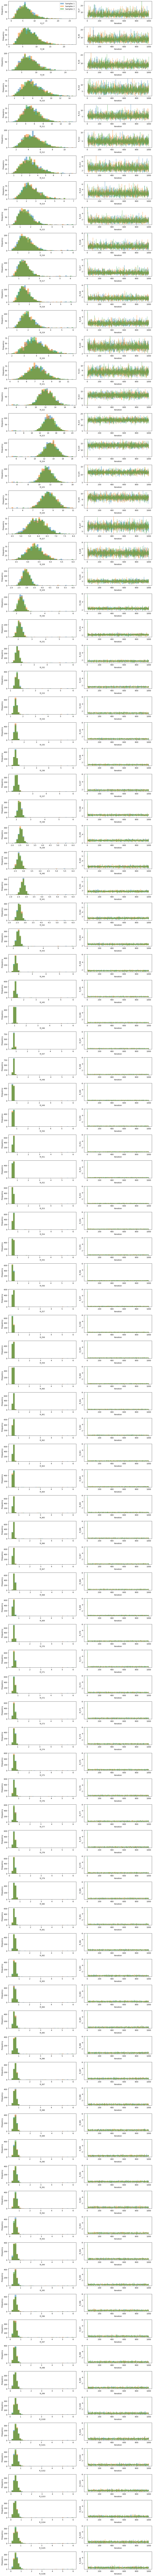

In [8]:
# Plot histograms of the parameters inferred for South West
param_names = []
for _ in range(pois_inference.lprior.n_parameters()):
            param_names.append('R_t{}'.format(_ + R_t_start))

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

We compute the confidence intervals for the reproduction number trajectories for ther Poisson noise model.

In [9]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
samples = samples[:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

pois_extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, len(times)),
    'Mean': np.mean(pois_extended_samples, axis=0),
    'Median': np.median(pois_extended_samples, axis=0),
    'Lower bound CI': np.quantile(pois_extended_samples, 0.025, axis=0),
    'Upper bound CI': np.quantile(pois_extended_samples, 0.975, axis=0),
    'Central Probability': 0.95*np.ones_like(times[R_t_start:])
})

In [10]:
# Uncomment this to write the results to CSV
#pois_intervals.to_csv('pois_rt.csv')

## Negative binomial noise model

As before, we write class that computes the log-likelihood and its partial derivatives used for the runnning NUTS sampling method in pints.

In [11]:
class NegativeBinomialBranchingLogLikelihood(PoissonBranchingLogLikelihood):
    """
    Log-likelihood of negative binomial branching process.

    Parameters
    ----------
    inc_data
        (pandas Dataframe) Dataframe of the numbers of new cases by time unit
        (usually days).
        Data stored in columns of with one for time and one for incidence
        number, respectively.
    daily_serial_interval
        (list) Unnormalised probability distribution of that the recipient
        first displays symptoms s days after the infector first displays
        symptoms.
    tau
        (numeric) size sliding time window over which the reproduction number
        is estimated.
    phi
        (numeric) Value of the overdispersion parameter for the negative
        binomial noise distribution.
    infer_phi
        (boolean) Indicator value of whether the overdispersion parameter
        for the negative binomial noise distribution is inferred or not.
    imported_inc_data
        (pandas Dataframe) contains numbers of imported new cases by time unit
        (usually days).
        Data stored in columns of with one for time and one for incidence
        number, respectively.
    epsilon
        (numeric) Proportionality constant of the R number for imported cases
        with respect to its analog for local ones.
    time_key
        label key given to the temporal data in the inc_data dataframe.
    inc_key
        label key given to the incidental data in the inc_data dataframe.

    """
    def __init__(self, inc_data, daily_serial_interval, tau, phi,
                 infer_phi=True, imported_inc_data=None, epsilon=None,
                 time_key='Time', inc_key='Incidence Number'):

        super().__init__(
            inc_data, daily_serial_interval, tau,
            imported_inc_data, epsilon, time_key, inc_key)

        self._infer_phi = infer_phi

        self.set_overdispersion(phi)

        # Precompute quantities for the log-likelihood computation and its
        # derivatives
        self._log_lik_precomp()

    def set_overdispersion(self, phi):
        """
        Updates overdispersion noise parameter for the model.

        Parameters
        ----------
        phi
            New value of the overdispersion parameter for the negative
            binomial noise distribution.

        """
        if not isinstance(phi, (int, float)):
            raise TypeError(
                'Value of overdispersion must be integer or float.')
        if phi <= 0:
            raise ValueError(
                'Value of overdispersion must be > 0. For overdispersion = 0, \
                please use `LocImpBranchProModel` class type.')

        self._overdispersion = phi

    def get_overdispersion(self):
        """
        Returns overdispersion noise parameter for the model.

        """
        return self._overdispersion

    def n_parameters(self):
        """
        Returns number of parameters for log-likelihood object.

        Returns
        -------
        int
            Number of parameters for log-likelihood object.

        """
        if self._infer_phi is True:
            return np.shape(self.cases_data)[0] - self._tau
        else:
            return np.shape(self.cases_data)[0] - self._tau - 1

    def _compute_log_likelihood(self, param):
        """
        Computes the log-likelihood evaluated a given choice of
        R numbers timeline for the branching process model and
        overdispersion parameter for the negative binomial noise
        distribution.

        Parameters
        ----------
        param : list
            Time-dependent R numbers trajectory and overdispersion parameter
            for which the log-likelihood is computed for.

        Returns
        -------
        float
            Value of the log-likelihood evaluated at the given choice of
            R numbers timeline and overdispersion parameter.
        """
        if self._infer_phi is True:
            phi = param[-1]
            r_profile = param[:-1]
        else:
            phi = self._overdispersion
            r_profile = param

        total_time = self.cases_times.max() - self.cases_times.min() + 1
        time_init_inf_r = self._tau + 1

        Ll = 0

        for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
            loggamma_slice_cases_phi = loggamma(
                self.slice_cases[_] + 1 / phi) - loggamma(1 / phi)

            Ll += np.sum(loggamma_slice_cases_phi - np.log(phi) / phi)
            Ll += np.log(r_profile[_]) * np.sum(self.slice_cases[_])

            log_phi_r_tau_window = np.zeros_like(self.tau_window[_])
            for tv, tau_val in enumerate(self.tau_window[_]):
                log_phi_r_tau_window[tv] = np.log(
                    1 / phi + r_profile[_] * self.sum_tau_window[_][tv])

            Ll += np.sum(
                np.multiply(self.slice_cases[_], self.log_tau_window[_]))
            Ll += - np.sum(np.multiply(
                self.slice_cases[_] + 1 / phi, log_phi_r_tau_window))

            Ll += - np.sum(self.ll_normalizing[_])

        return Ll

    def _log_lik_precomp(self):
        """
        Precompute quantities for the log-likelihood computation and its
        derivatives.
        """
        self.slice_cases = []
        self.ll_normalizing = []
        self.tau_window = []
        self.tau_window_imp = []
        self.log_tau_window = []
        self.sum_tau_window = []

        total_time = self.cases_times.max() - self.cases_times.min() + 1
        time_init_inf_r = self._tau + 1

        for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
            # get cases in tau window
            start_window = time - self._tau
            end_window = time + 1

            slice_cases = self.cases_data[(start_window-1):(end_window-1)]
            self.slice_cases.append(slice_cases)

            self.ll_normalizing.append(loggamma(slice_cases + 1))

            try:
                # try to shift the window by 1 time point
                tau_window = (tau_window[1:] +  # noqa
                              [self._infectious_individuals(self.cases_data,
                                                            end_window-1)])
                tau_window_imp = (tau_window_imp[1:] +  # noqa
                                  [self._infectious_individuals(
                                    self.imp_cases_data,
                                    end_window-1)])

            except UnboundLocalError:
                # First iteration, so set up the sliding window
                tau_window = self._infectives_in_tau(
                    self.cases_data, start_window, end_window)
                tau_window_imp = self._infectives_in_tau(
                    self.imp_cases_data, start_window, end_window)

            self.tau_window.append(tau_window)
            self.tau_window_imp.append(tau_window_imp)

            log_tau_window = np.zeros_like(tau_window)
            for tv, tau_val in enumerate(tau_window):
                if (tau_val == 0) and (tau_window_imp[tv] == 0):
                    log_tau_window[tv] = 0
                else:
                    log_tau_window[tv] = np.log(
                        tau_window[tv] + self.epsilon * tau_window_imp[tv])

            self.log_tau_window.append(log_tau_window)
            self.sum_tau_window.append(
                (np.array(tau_window) +
                 self.epsilon * np.array(tau_window_imp)).tolist())

    def _compute_derivative_log_likelihood(self, param):
        """
        Computes the parameter-dependent derivatives of the
        model log-likelihood evaluated a given choice of
        R numbers timeline and overdispersion parameter for the negative
        binomial noise distribution.

        Parameters
        ----------
        param : list
            Time-dependent R numbers trajectory and overdispersion parameter
            for which the log-likelihood is computed for.

        Returns
        -------
        list
            List of the parameter-dependent derivatives the log-likelihood
            evaluated at the given choice of R numbers timeline and
            overdispersion parameter.
        """
        if self._infer_phi is True:
            phi = param[-1]
            r_profile = param[:-1]
        else:
            phi = self._overdispersion
            r_profile = param

        total_time = self.cases_times.max() - self.cases_times.min() + 1
        time_init_inf_r = self._tau + 1

        dLl = []
        dLl_phi = 0

        for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
            inv_phi_r_tau_window = np.zeros_like(self.tau_window[_])
            inv_phi_r_tau_window2 = np.zeros_like(self.tau_window[_])
            log_phi_r_tau_window = np.zeros_like(self.tau_window[_])
            for tv, tau_val in enumerate(self.tau_window[_]):
                inv_phi_r_tau_window[tv] = (self.sum_tau_window[_][tv]) \
                    * np.reciprocal(
                    1 / phi + r_profile[_] * self.sum_tau_window[_][tv])
                inv_phi_r_tau_window2[tv] = np.reciprocal(
                    1 / phi + r_profile[_] * self.sum_tau_window[_][tv])
                log_phi_r_tau_window[tv] = np.log(
                    1 / phi + r_profile[_] * self.sum_tau_window[_][tv])

            dLl.append(
                (1/r_profile[_]) * np.sum(self.slice_cases[_]) - np.sum(
                    np.multiply(self.slice_cases[_] + 1 / phi,
                                inv_phi_r_tau_window)))

            dLl_phi += np.sum(
                digamma(self.slice_cases[_] + 1 / phi) - digamma(1 / phi) +
                np.log(1 / phi) + 1)

            dLl_phi -= np.sum(log_phi_r_tau_window) + np.sum(np.multiply(
                self.slice_cases[_] + 1 / phi, inv_phi_r_tau_window2))

        dLl_phi *= - 1 / (phi ** 2)

        if self._infer_phi is True:
            dLl.append(dLl_phi)

        return dLl

Just as we have done in the Poisson noise model case, we create a LogPosterior object compartible with the PINTS infrastuture that is then used to run the sampling method or oprimisation method of our choice. 

In [12]:
class NegativeBinomialBranchingRunner(PoissonBranchingRunner):
    """
    Runs optimisation or inference of parameters of the
    negative binomial branching process model in a PINTS framework.

    Parameters
    ----------
    inc_data
        (pandas Dataframe) Dataframe of the numbers of new cases by time unit
        (usually days).
        Data stored in columns of with one for time and one for incidence
        number, respectively.
    daily_serial_interval
        (list) Unnormalised probability distribution of that the recipient
        first displays symptoms s days after the infector first displays
        symptoms.
    tau
        (numeric) Size sliding time window over which the reproduction number
        is estimated.
    phi
        (numeric) Value of the overdispersion parameter for the negative
        binomial noise distribution.
    alpha
        the shape parameter of the Gamma distribution of the prior.
    beta
        the rate parameter of the Gamma distribution of the prior.
    infer_phi
        (boolean) Indicator value of whether the overdispersion parameter
        for the negative binomial noise distribution is inferred or not.
    phi_shape
        the shape parameter of the Gamma distribution of the prior of
        the overdispersion.
    phi_rate
        the rate parameter of the Gamma distribution of the prior of
        the overdispersion.
    phi_prior
        (pints.LogPrior) Prior distribution of the phi parameter. Can be
        non-Gamma.
    imported_inc_data
        (pandas Dataframe) contains numbers of imported new cases by time unit
        (usually days).
        Data stored in columns of with one for time and one for incidence
        number, respectively.
    epsilon
        (numeric) Proportionality constant of the R number for imported cases
        with respect to its analog for local ones.
    time_key
        label key given to the temporal data in the inc_data dataframe.
    inc_key
        label key given to the incidental data in the inc_data dataframe.

    """
    def __init__(self, inc_data, daily_serial_interval, tau, phi, alpha, beta,
                 infer_phi=False, phi_shape=None, phi_rate=None,
                 phi_prior=None, imported_inc_data=None, epsilon=None,
                 time_key='Time', inc_key='Incidence Number'):
        super().__init__(
            inc_data, daily_serial_interval, tau, alpha, beta,
            imported_inc_data, epsilon, time_key, inc_key)

        self._infer_phi = infer_phi

        loglikelihood = NegativeBinomialBranchingLogLikelihood(
            inc_data, daily_serial_interval, tau, phi, infer_phi,
            imported_inc_data, epsilon, time_key, inc_key)

        # Create a prior and compute prior std vector
        list_priors = [pints.GammaLogPrior(alpha, beta) for _ in range(
            np.shape(
                loglikelihood.cases_data)[0] - loglikelihood._tau - 1)]

        logprior_std = [np.sqrt(alpha) / beta for _ in range(
            np.shape(
                loglikelihood.cases_data)[0] - loglikelihood._tau - 1)]

        if infer_phi is True:
            if phi_prior is not None:
                list_priors.append(phi_prior)
                logprior_std.append(1)
            else:
                list_priors.append(pints.GammaLogPrior(phi_shape, phi_rate))
                logprior_std.append(np.sqrt(phi_shape) / phi_rate)

        logprior = pints.ComposedLogPrior(*list_priors)

        self.lprior = logprior
        self.logprior_std = logprior_std
        self.ll = loglikelihood

        # Create a posterior log-likelihood (log(likelihood * prior))
        self._log_posterior = pints.LogPosterior(loglikelihood, logprior)

    def run_inference(self, num_iter):
        """
        Runs the parameter inference routine for the Poisson branching process
        model.

        Parameters
        ----------
        num_iter : integer
            Number of iterations the MCMC sampler algorithm is run for.

        Returns
        -------
        numpy.array
            3D-matrix of the proposed parameters for each iteration for
            each of the chains of the MCMC sampler.

        """
        # Starting points arround from prior mean
        x0 = [
            (np.array(self.lprior.mean()) + 0.1 *
                np.array(self.logprior_std)).tolist(),
            self.lprior.mean(),
            (np.array(self.lprior.mean()) + 0.2 *
                np.array(self.logprior_std)).tolist()]

        transformation = pints.RectangularBoundariesTransformation(
            [0] * self.lprior.n_parameters(),
            [200] * self.lprior.n_parameters()
        )

        # Create MCMC routine
        mcmc = pints.MCMCController(
            self._log_posterior, 3, x0, method=pints.NoUTurnMCMC,
            transformation=transformation)
        mcmc.set_max_iterations(num_iter)
        mcmc.set_log_to_screen(True)
        # mcmc.set_parallel(True)

        print('Running...')
        chains = mcmc.run()
        print('Done!')

        param_names = []

        if self._infer_phi is True:
            for _ in range(self.lprior.n_parameters() - 1):
                param_names.append('R_t{}'.format(_ + 1 + self.ll._tau))
            param_names.append('Phi')
        else:
            for _ in range(self.lprior.n_parameters()):
                param_names.append('R_t{}'.format(_ + 1 + self.ll._tau))

        # Check convergence and other properties of chains
        results = pints.MCMCSummary(
            chains=chains, time=mcmc.time(),
            parameter_names=param_names)
        print(results)

        return chains

    def run_optimisation(self):
        """
        Runs the initial conditions optimisation routine for the Poisson
        branching process model.

        Returns
        -------
        numpy.array
            Matrix of the optimised parameters at the end of the optimisation
            procedure.
        float
            Value of the log-posterior at the optimised point in the free
            parameter space.

        """
        # Starting points
        x0 = [1.5] * self.lprior.n_parameters()
        transformation = pints.RectangularBoundariesTransformation(
            [0] * self.lprior.n_parameters(),
            [200] * self.lprior.n_parameters()
        )

        # Create optimisation routine
        optimiser = pints.OptimisationController(
            self._log_posterior, x0, sigma0=1,
            method=pints.CMAES,
            transformation=transformation)

        optimiser.set_max_unchanged_iterations(100, 1)

        found_ics, found_posterior_val = optimiser.run()

        print(found_ics, found_posterior_val)

        print("Optimisation phase is finished.")

        return found_ics, found_posterior_val

We set our Gamma prior parameters $a$ and $b$, the mean and variance for the Gamma prior of the $\phi$ overdispersion parameter, as well as the sliding window size $\tau=6$.

In [13]:
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

phi = 0.0005
phi_mean = 0.5
phi_var = 10**(-0)
phi_rate = phi_var / phi_mean
phi_shape = phi_mean / phi_rate

negbin_inference = NegativeBinomialBranchingRunner(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    tau=tau,
    phi=phi,
    alpha=a,
    beta=b,
    infer_phi=True,
    phi_shape=phi_shape,
    phi_rate=phi_rate)

We run the NUTS sampling algorithm with 1000 iterations and a warm-up period of 500. We also plot the pints diagnostics plots to check quality of chain convergance.

In [14]:
samples = negbin_inference.run_inference(num_iter=1000)

Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time    
0     18     0.125    2       0.125    2       0.125    2        0:00.2
1     21     0.25     1       0.25     1       0.25     1        0:00.2
2     24     0.25     1       0.25     1       0.25     1        0:00.3
3     45     0.5      4       0.5      2       0.667    2        0:00.5
20    1410   0.768    24      0.757    26      0.764    27       0:15.3
40    2589   0.764    18      0.763    19      0.747    20       0:28.2
60    3540   0.742    15      0.777142 14      0.768    16       0:38.5
80    4563   0.769    20      0.748    16      0.758    15       0:49.7
100   5571   0.752    16      0.707    15      0.723    13       1:00.6
120   6225   0.719    11      0.723    14      0.756    8        1:07.8
140   7029   0.749    13      0.774    12      0.744    10       1:16.5
160   7563   0.723    9       0.721    9       0.711   

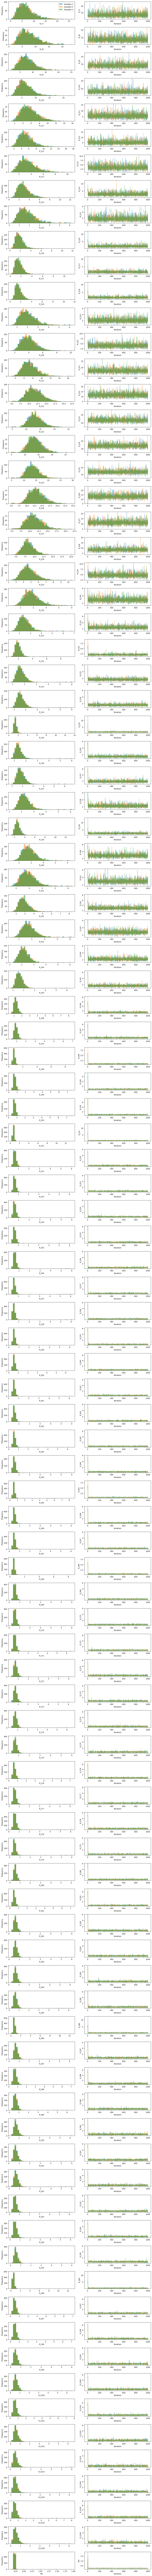

In [15]:
# Plot histograms of the parameters inferred for South West
param_names = []

if negbin_inference._infer_phi is True:
    for _ in range(negbin_inference.lprior.n_parameters()-1):
        param_names.append('R_t{}'.format(_ + R_t_start))
    param_names.append('Phi')

    pints.plot.trace(samples, parameter_names=param_names)
    plt.show()

    # Eliminate burn-in iterations (1/2 of the chain lengths)
    samples_old = samples.copy()
    samples = samples[:, 500:, :-1]

else:
    for _ in range(negbin_inference.lprior.n_parameters()):
        param_names.append('R_t{}'.format(_ + R_t_start))

    pints.plot.trace(samples, parameter_names=param_names)
    plt.show()

    # Eliminate burn-in iterations (1/2 of the chain lengths)
    samples_old = samples.copy()
    samples = samples[:, 500:, :]

We compute the confidence intervals for the reproduction number trajectories for ther Negative Binomial noise model.

In [16]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

negbin_extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

negbin_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, len(times)),
    'Mean': np.mean(negbin_extended_samples, axis=0),
    'Median': np.median(negbin_extended_samples, axis=0),
    'Lower bound CI': np.quantile(negbin_extended_samples, 0.025, axis=0),
    'Upper bound CI': np.quantile(negbin_extended_samples, 0.975, axis=0),
    'Central Probability': 0.95*np.ones_like(times[R_t_start:])
})


In [17]:
#negbin_intervals.to_csv('negbin_rt.csv')

We can plot the two inferred reproduction number trajectories against one another:

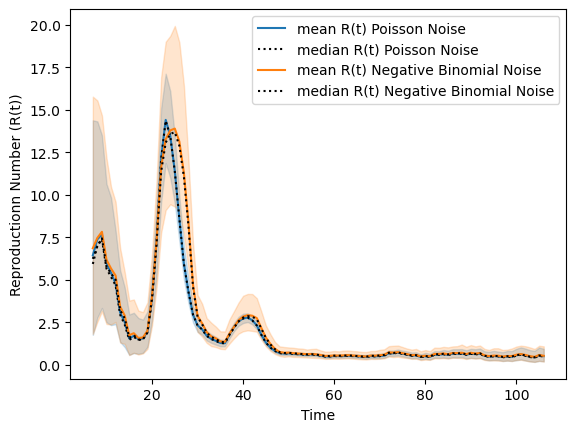

In [18]:
fig, ax = plt.subplots()

# Plot poisson noise model fitter Rt.
ax.plot(
    pois_intervals['Time Points'],
    pois_intervals['Mean'],
    '-', color='tab:blue', label = 'mean R(t) Poisson Noise')

ax.plot(
    pois_intervals['Time Points'],
    pois_intervals['Median'],
    ':', color='black', label = 'median R(t) Poisson Noise')

ax.fill_between(
    pois_intervals['Time Points'],
    pois_intervals['Lower bound CI'],
    pois_intervals['Upper bound CI'],
    alpha=0.2, color='tab:blue')

# Plot negative binomial noise model fitter Rt.
ax.plot(
    negbin_intervals['Time Points'],
    negbin_intervals['Mean'],
    '-', color='tab:orange', label = 'mean R(t) Negative Binomial Noise')

ax.plot(
    negbin_intervals['Time Points'],
    negbin_intervals['Median'],
    ':', color='black', label = 'median R(t) Negative Binomial Noise')

ax.fill_between(
    negbin_intervals['Time Points'],
    negbin_intervals['Lower bound CI'],
    negbin_intervals['Upper bound CI'],
    alpha=0.2, color='tab:orange')

ax.legend(loc = 'upper right')
plt.xlabel('Time')
plt.ylabel('Reproductionn Number (R(t))')
plt.show()

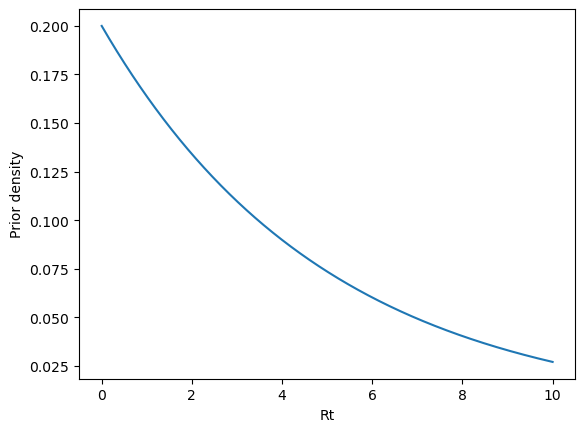

In [19]:
Rt_grid = np.linspace(0, 10, 1000)
prior = []
for rt in Rt_grid:
    prior.append(np.exp(negbin_inference.lprior._priors[0]([rt,])))

plt.plot(Rt_grid, prior)
plt.xlabel('Rt')
plt.ylabel('Prior density')
plt.show()